# Kaggle 데이터 이용한 Prophet

In [114]:
%matplotlib inline

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import os
import time
import datetime

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from fbprophet import Prophet

import sklearn.metrics as skm
# from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold
from scipy import stats

# plt.style.use('fivethirtyeight')


# from dateutil.relativedelta import relativedelta # working with dates with style
# from scipy.optimize import minimize              # for function minimization

# SARIMA 
# import statsmodels.formula.api as smf            # statistics and econometrics
# import statsmodels.tsa.api as smt
import statsmodels.api as sm

# from itertools import product                    # some useful functions
# from tqdm import tqdm_notebook

#import warnings                                  # `do not disturbe` mode
#warnings.filterwarnings('ignore')

import lightgbm as lgb
import xgboost as xgb

# from fastai.imports import *
# from fastai.structured import *
# from fbprophet import Prophet

# def ignore_warn(*args, **kwargs):
#     pass
# warnings.warn = ignore_warn


In [97]:
# load input files
PATH = '../input'

train = pd.read_csv(f'{PATH}/train.csv', parse_dates=['date'], index_col=['date'])
test = pd.read_csv(f'{PATH}/test.csv', parse_dates=['date'], index_col=['date'])
samples = pd.read_csv(f'{PATH}/sample_submission.csv')

#### Notes on using Kaggle:

* Input data files can be loaded to `../input` directory
* When reading data to pandas via `pd.read_csv`, set index column by `index_col` and parse date by `parse_dates` option.

#### Imported packages
* `xgboost`, `lightgbm` : Faster gradient boosting algorithms
* 

#### Tutorials and References

1. [Time series forecasting using Prophet Kaggle](https://www.kaggle.com/robikscube/tutorial-time-series-forecasting-with-prophet#Hourly-Time-Series-Forecasting-using-Facebook's-Prophet)
2. [Open Machine Learning Course, Medium](https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-9-time-series-analysis-in-python-a270cb05e0b3)


## Basic Prophet

거의 1번 튜토리얼 따라 함. 시간 + 빠르게 하기 위해 store ==1, item==1만으로 우선 해봄.

아래가 데이터 전반적 그림:

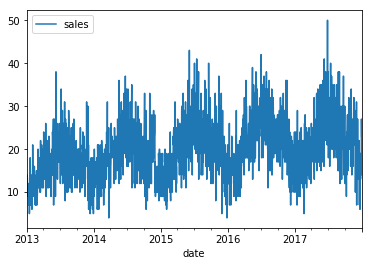

In [115]:
## For the sake of simplicity, we'll start with store 1 and item 1.

# plot input train data
pd.plotting.register_matplotlib_converters()   # for time series plotting

pld = train.loc[(train.store==1) & (train.item==1)].reset_index()
pld.plot(kind='line', x='date', y='sales')
plt.show()

#https://darektidwell.com/typeerror-float-argument-must-be-a-string-or-a-number-not-period-facebook-prophet-and-pandas/

**matplotlib plotting problems with Prophet**

https://darektidwell.com/typeerror-float-argument-must-be-a-string-or-a-number-not-period-facebook-prophet-and-pandas/

2017년 기준으로 train / test 나누어서 예측해 본다. (challenge의 test.csv 파일에는 답이 없음)

In [116]:
# ridx = random.sample(range(train_df.shape[0]),10000)
split_date = '2017-01-01'
sales_train = train.loc[train.index < split_date].copy()
sales_test = train.loc[train.index >= split_date].copy()

# Rename columns for Prophet

train_df = sales_train.copy().reset_index().rename(columns={'date':'ds', 'sales':'y'})
test_df = sales_test.copy().reset_index().rename(columns={'date':'ds', 'sales':'y'})


In [117]:
import time

store = 1
item = 1

train_df2 = train_df.loc[(train_df.store == store) & (train_df.item == item)]
test_df2 = test_df.loc[(test_df.store == store) & (test_df.item == item)]


tcheck = time.time()
model = Prophet()
# model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
model.fit(train_df2)
print((time.time() - tcheck))

forecast = model.predict(test_df2)


0.31171488761901855


코드 자체는 간단하다. Store, item 나누지 않고 돌렸을 때는 무한정 돌아가던게 나누니 순식간.

Prophet에서 제공(?)되는 plot_components를 이용해서 forecast 결과도 보기 쉽다. (문제는 해석...)

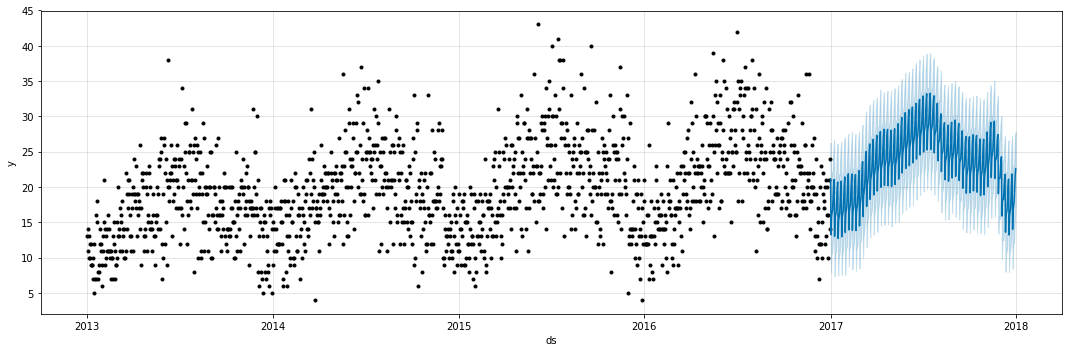

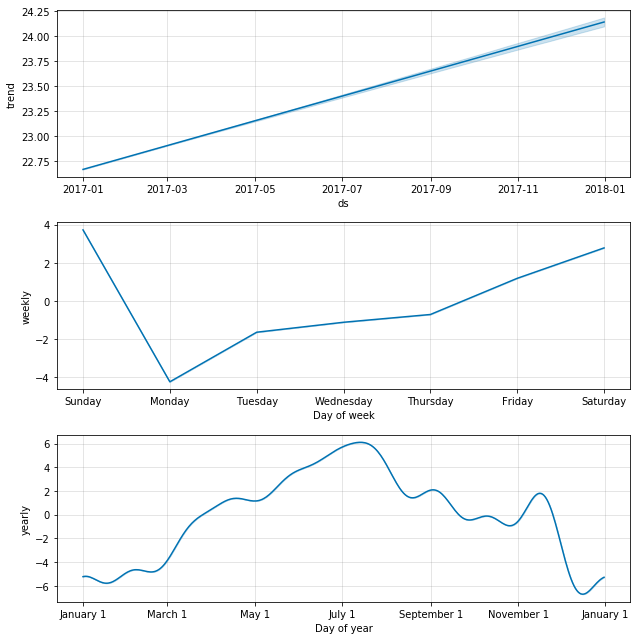

In [118]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(forecast, ax=ax)
# Plot the components
fig = model.plot_components(forecast)

위 그림이 train, test 예측되는 그래프, 아래는 trend, monthly, yearly 변화를 보인다. 전반적으로 sales는 점점 늘어나고 있는 추세이고 주말에 peak를 찍고 월요일에는 최악인 것으로 보임. 그리고 겨울보다 여름에 더 많이 팔리는 추세.

Prophet에서 seasonality도 모델에 집어넣을 수 있다 하니 조금 있다 해보고 비교 해 보는 것으로...

첫 번째 그림과 실제 값과 비교하기 위해 아래 처럼 그려 볼 수 있다. *(red : actual, blue : predicted)*

***python 그리기 note :*** * `plt.subplots`로 여러 plot 지정 혹은 겹쳐 그리기 가능*

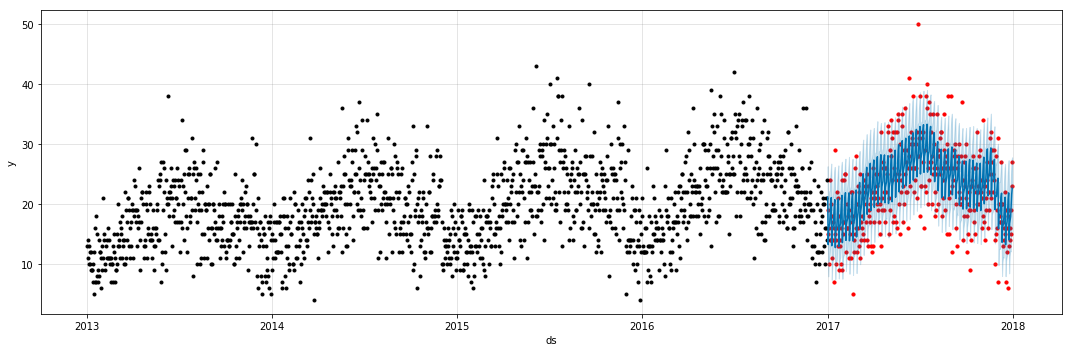

In [119]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(test_df2['ds'], test_df2['y'], color='r', s = 10)
fig = model.plot(forecast, ax=ax)


MAPE (Mean Absolute Percentage Error) : Forecasting에서 잘 이용되는 오차 metric...?

*From [Wikipedia](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error) :*

> The mean absolute percentage error (MAPE), also known as mean absolute percentage deviation (MAPD), is a measure of prediction accuracy of a forecasting method in statistics, for example in trend estimation, also used as a loss function for regression problems in machine learning.

In [120]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=test_df2['y'], y_pred=forecast['yhat'])

22.261182711933024

MAPE = 22.26

## Adding Seasonality, Holidays etc...

공식 [Prophet github](https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html)에 더 자세한 설명...

튜토리얼 따라서 빠르게 US의 holiday data 얻어서 Prophet이 읽을 수 있는 형식으로 변환한다. 추가로 튜터리얼 대로 슈퍼보울 데이터도... (columns : ds, holiday)

In [121]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()
train_holidays = cal.holidays(start=train_df['ds'].min(), end=train_df['ds'].max())
test_holidays = cal.holidays(start=test_df['ds'].min(), end=test_df['ds'].max())

# Create a dataframe with holiday, ds columns
holiday_index = train_df2.ds.isin([d.date() for d in cal.holidays()])
holiday_df = train_df2.loc[holiday_index].reset_index().rename(columns={'Datetime':'ds'})
holiday_df.loc[: ,'holiday'] = 'USFederalHoliday'
holiday_df['lower_window'] = 0
holiday_df['upper_window'] = 4
holiday_df = holiday_df.drop(['index','store','item','y'], axis=1)
print(holiday_df.head())


playoffs = pd.DataFrame({
    'ds' : pd.to_datetime(['2013-01-12','2013-07-12','2013-12-24','2014-01-12','2014-07-12','2014-07-19','2014-07-02','2014-12-24','2015-07-11','2015-12-24',
                           '2016-07-17','2016-07-24','2016-07-07','2016-07-24','2016-12-24','2017-07-17','2017-07-24','2017-07-07','2017-12-24']),
    'holiday' : 'playoff',
    'lower_window' : 0,
    'upper_window' : 2}
)

superbowls = pd.DataFrame({
    'ds': pd.to_datetime(['2013-01-01','2013-01-21','2013-02-14','2013-02-18','2013-05-27','2013-07-04','2013-09-02','2013-10-14','2013-11-11','2013-11-28',
                          '2013-12-25','2014-01-01','2014-01-20','2014-02-14','2014-02-17','2014-05-26','2014-07-04','2014-09-01','2014-10-13','2014-11-11',
                          '2014-11-27','2014-12-25','2015-01-01','2015-01-19','2015-02-14','2015-02-16','2015-05-25','2015-07-03','2015-09-07','2015-10-12',
                          '2015-11-11','2015-11-26','2015-12-25','2016-01-01','2016-01-18','2016-02-14','2016-02-15','2016-05-30','2016-07-04','2016-09-05',
                          '2016-10-10','2016-11-11','2016-11-24','2016-12-25','2017-01-02','2017-01-16','2017-02-14','2017-02-20','2017-05-29','2017-07-04',
                          '2017-09-04','2017-10-09','2017-11-10','2017-11-23','2017-12-25','2018-01-01','2018-01-15','2018-02-14','2018-02-19']),
    'holiday': 'superbowl',
    'lower_window': 0,
    'upper_window': 3,
})

holidays = pd.concat((holiday_df, playoffs, superbowls))
print(holidays)

          ds           holiday  lower_window  upper_window
0 2013-01-01  USFederalHoliday             0             4
1 2013-01-21  USFederalHoliday             0             4
2 2013-02-18  USFederalHoliday             0             4
3 2013-05-27  USFederalHoliday             0             4
4 2013-07-04  USFederalHoliday             0             4
           ds           holiday  lower_window  upper_window
0  2013-01-01  USFederalHoliday             0             4
1  2013-01-21  USFederalHoliday             0             4
2  2013-02-18  USFederalHoliday             0             4
3  2013-05-27  USFederalHoliday             0             4
4  2013-07-04  USFederalHoliday             0             4
..        ...               ...           ...           ...
54 2017-12-25         superbowl             0             3
55 2018-01-01         superbowl             0             3
56 2018-01-15         superbowl             0             3
57 2018-02-14         superbowl             0 

In [ ]:
# train_df2.loc[:, 'is_holiday'] = holiday_index.values

# train_df2 = train_df.loc[(train_df.store == store) & (train_df.item == item)]

그 다음에는 그냥 먹이면 됨. (확실히 하기 위해 model 만들 때 seasonlity option들도 다 주는 것으로)

In [122]:
tcheck = time.time()
model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True, holidays = holidays)
model.fit(train_df2)
print((time.time() - tcheck))

forecast = model.predict(test_df2)

0.5286872386932373


22.30653953009312

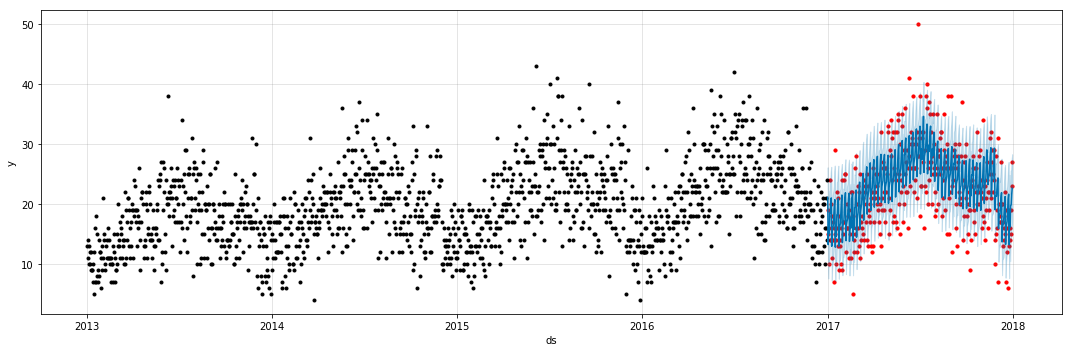

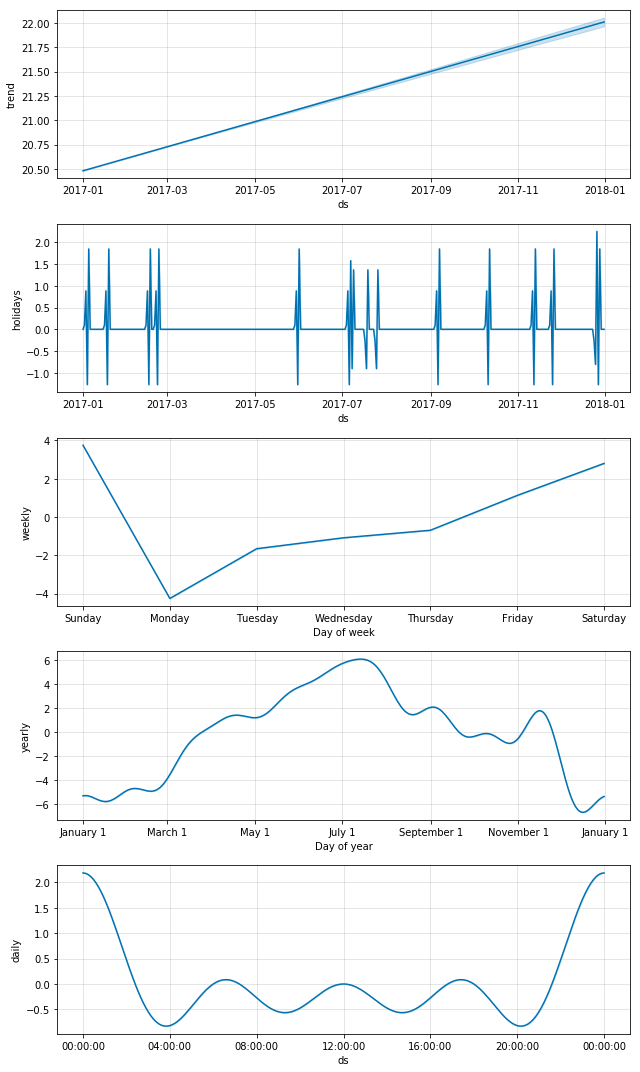

In [123]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(test_df2['ds'], test_df2['y'], color='r', s = 10)
fig = model.plot(forecast, ax=ax)

fig = model.plot_components(forecast)

mean_absolute_percentage_error(y_true=test_df2['y'], y_pred=forecast['yhat'])

MAPE = 22.30

별 차이 없음.